# Week 5: Simple single-cell RNA-seq analysis

1. fetch some single-cell data and create a cell-gene expression matrix and the associated AnnData object;
2. cluster the data to understand the cell structure; and
3. annotate the data with biologically relevant information.

All steps are based on Single-cell Best Practices Book (https://www.sc-best-practices.org/).

## Step 0: Setup

In [1]:
from pathlib import Path
import urllib.request
import subprocess
import gzip
import shutil
import tarfile
import pyroe

# Setup directories
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

toy_ref_read = data_dir / "toy_ref_read"
fastq_dir = toy_ref_read / "toy_read_fastq"
ref_dir = toy_ref_read / "toy_human_ref"

# Input files
r1_fastq = fastq_dir / "selected_R1_reads.fastq"
r2_fastq = fastq_dir / "selected_R2_reads.fastq"
genome_fa = ref_dir / "fasta" / "genome.fa"
genes_gtf = ref_dir / "genes" / "genes.gtf"
whitelist_path = data_dir / "whitelist.txt"

# Output directories
output_dir = data_dir / "alevin_output"
index_dir = output_dir / "salmon_index"
map_dir = output_dir / "map"
quant_dir = output_dir / "quant"

for d in [output_dir, index_dir, map_dir, quant_dir]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Working directory: {Path.cwd()}")
print(f"Data directory: {data_dir}")

Working directory: /mnt/c/Users/Nick/documents/github/fall25-csc-bioinf/week6/code
Data directory: data


/home/nick/miniconda3/envs/scrna/lib/python3.10/site-packages/pyranges/__init__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Step 1: Download and Extract Data

In [2]:
# Extract dataset if not already done
toy_dataset_gz = data_dir / "toy_read_ref_set.tar.gz"

if not r1_fastq.exists():
    print("Extracting dataset...")
    with tarfile.open(toy_dataset_gz, 'r:gz') as tar:
        tar.extractall(path=data_dir)
    print("Dataset extracted")
else:
    print("Dataset already extracted")

# Download whitelist if needed
if not whitelist_path.exists():
    print("Downloading whitelist...")
    whitelist_url = "https://raw.githubusercontent.com/f0t1h/3M-february-2018/master/3M-february-2018.txt.gz"
    whitelist_gz = data_dir / "3M-february-2018.txt.gz"
    
    urllib.request.urlretrieve(whitelist_url, whitelist_gz)
    with gzip.open(whitelist_gz, 'rb') as f_in:
        with open(whitelist_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    whitelist_gz.unlink()
    print(f"Whitelist saved to: {whitelist_path}")
else:
    print("Whitelist already exists")

# Verify required files exist
required_files = {
    "R1 FASTQ": r1_fastq,
    "R2 FASTQ": r2_fastq,
    "Genome FASTA": genome_fa,
    "GTF": genes_gtf,
    "Whitelist": whitelist_path
}

print("\nVerifying required files:")
all_exist = True
for name, path in required_files.items():
    exists = path.exists()
    print(f"  {name}: {'✓' if exists else '✗'}")
    all_exist = all_exist and exists

if not all_exist:
    raise FileNotFoundError("Some required files are missing!")

print("\n✓ All required files present")

Dataset already extracted
Whitelist already exists

Verifying required files:
  R1 FASTQ: ✓
  R2 FASTQ: ✓
  Genome FASTA: ✓
  GTF: ✓
  Whitelist: ✓

✓ All required files present


## Step 2: Alevin-fry Alignment and Quantification

In [3]:
# Configuration
READ_LENGTH = 91
THREADS = "4"
LIBTYPE = "ISR"
CHEMISTRY = "--chromiumV3"

def run_cmd(cmd, description=""):
    """Run a command and print output."""
    if description:
        print(f"\n{description}")
    print(f"Running: {' '.join(map(str, cmd))}")
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error: {result.stderr}")
        raise RuntimeError(f"Command failed: {' '.join(map(str, cmd))}")
    return result

# 2.1: Build splici transcriptome
splici_fa = index_dir / "splici_fl86.fa"
if not splici_fa.exists():
    print("\n[1/6] Building splici transcriptome with pyroe...")
    pyroe.make_splici_txome(
        gtf_path=str(genes_gtf),
        genome_path=str(genome_fa),
        read_length=READ_LENGTH,
        output_dir=str(index_dir),
        flank_trim_length=5,
        filename_prefix="splici"
    )
    print("✓ Splici transcriptome created")
else:
    print("\n[1/6] Splici transcriptome already exists")

# 2.2: Build salmon index
salmon_idx_dir = index_dir / "salmon_idx"
if not (salmon_idx_dir / "hash.bin").exists():
    run_cmd(
        ["salmon", "index", "-t", splici_fa, "-i", salmon_idx_dir, "-p", THREADS],
        "[2/6] Building salmon index..."
    )
    print("✓ Salmon index created")
else:
    print("\n[2/6] Salmon index already exists")

# 2.3: Run salmon alevin
map_rad = map_dir / "map.rad"
if not map_rad.exists():
    run_cmd(
        ["salmon", "alevin", "-l", LIBTYPE, "-i", salmon_idx_dir,
         "-1", r1_fastq, "-2", r2_fastq, "-o", map_dir,
         "-p", THREADS, "--sketch", CHEMISTRY],
        "[3/6] Running salmon alevin (mapping)..."
    )
    print("✓ Mapping complete")
else:
    print("\n[3/6] Mapping already complete")

# 2.4: Generate permit list
permit_list = quant_dir / "permit_list.txt"
if not permit_list.exists():
    run_cmd(
        ["alevin-fry", "generate-permit-list", "-i", map_dir,
         "-o", quant_dir, "-u", whitelist_path, "-d", "fw"],
        "[4/6] Generating permit list..."
    )
    print("Permit list generated")
else:
    print("\n[4/6] Permit list already exists")

# 2.5: Collate
collated_rad = quant_dir / "map.collated.rad"
if not collated_rad.exists():
    run_cmd(
        ["alevin-fry", "collate", "-r", map_dir, "-i", quant_dir, "-t", THREADS],
        "[5/6] Collating..."
    )
    print("Collation complete")
else:
    print("\n[5/6] Collation already complete")

# 2.6: Quantify
quant_mtx = quant_dir / "alevin" / "quants_mat.mtx"
t2g_file = index_dir / "splici_fl86_t2g_3col.tsv"

if not quant_mtx.exists():
    run_cmd(
        ["alevin-fry", "quant", "-i", quant_dir, "-o", quant_dir,
         "-r", "cr-like", "-m", t2g_file, "-t", THREADS, "--use-mtx"],
        "[6/6] Quantifying..."
    )
    print("Quantification complete")
else:
    print("\n[6/6] Quantification already complete")


[1/6] Splici transcriptome already exists

[2/6] Building salmon index...
Running: salmon index -t data/alevin_output/salmon_index/splici_fl86.fa -i data/alevin_output/salmon_index/salmon_idx -p 4
✓ Salmon index created

[3/6] Mapping already complete

[4/6] Generating permit list...
Running: alevin-fry generate-permit-list -i data/alevin_output/map -o data/alevin_output/quant -u data/whitelist.txt -d fw
Permit list generated

[5/6] Collation already complete

[6/6] Quantification already complete


## Step 3: Cell Clustering

Perform cell clustering (via Leiden modularity algorithm). Output the clustering plot.

Loading data from alevin-fry output...
Loading from:
  Matrix: True
  Barcodes: True
  Features: True
Matrix shape from file: (139, 60)
Number of barcodes: 139
Number of features: 60
Final matrix shape: (139, 60) (cells x genes)
Loaded data: 139 cells × 60 genes

Performing QC filtering...
After filtering: 123 cells × 56 genes

Normalizing data...
Checking for variable genes...


/home/nick/miniconda3/envs/scrna/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Using 30 highly variable genes
Scaling and computing PCA...
Computing neighborhood graph...


/home/nick/miniconda3/envs/scrna/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/nick/miniconda3/envs/scrna/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing UMAP...
Performing Leiden clustering...

Generating clustering plots...


/tmp/ipykernel_81942/370259949.py:121: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.3)


✓ Clustering plot saved to: data/clustering_plot.png


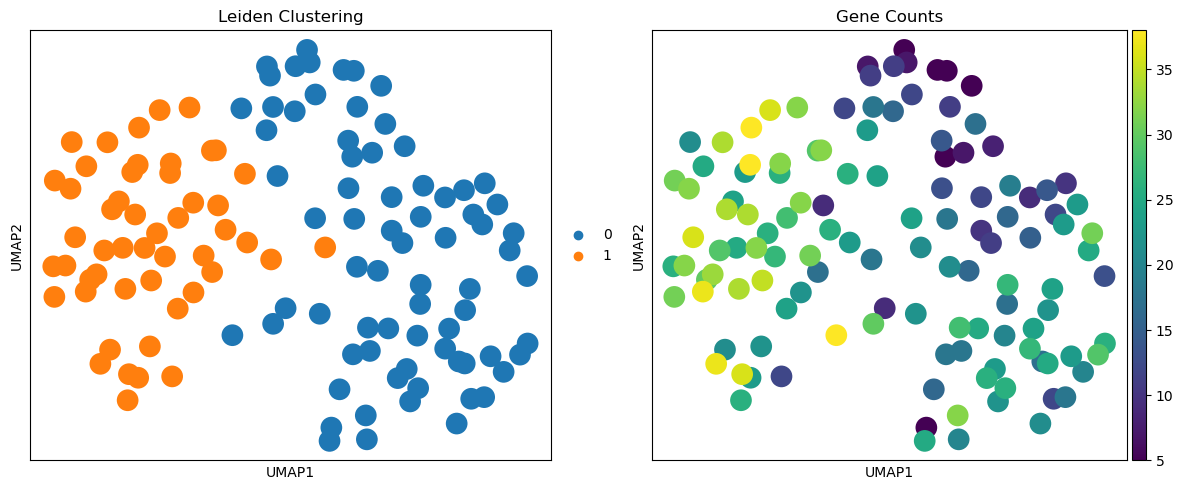


Found 2 clusters

Cluster sizes:
0    73
1    50
Name: leiden, dtype: int64

QC Summary:
  Total cells: 123
  Total genes: 30
  Median genes per cell: 23
  Median UMI per cell: 55
✓ Processed data saved to: data/adata_clustered.h5ad


In [4]:
import scanpy as sc
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd

# Load the quantification data from alevin-fry format
print("Loading data from alevin-fry output...")

# alevin-fry outputs: quants_mat.mtx, quants_mat_rows.txt, quants_mat_cols.txt
mtx_file = quant_dir / 'alevin' / 'quants_mat.mtx'
barcodes_file = quant_dir / 'alevin' / 'quants_mat_rows.txt'
features_file = quant_dir / 'alevin' / 'quants_mat_cols.txt'

# Check if files exist
print(f"Loading from:")
print(f"  Matrix: {mtx_file.exists()}")
print(f"  Barcodes: {barcodes_file.exists()}")
print(f"  Features: {features_file.exists()}")

# Read the matrix (in COO format initially)
mtx = sio.mmread(mtx_file)
print(f"Matrix shape from file: {mtx.shape}")

# Read barcodes (cell IDs) - these are the rows
barcodes = pd.read_csv(barcodes_file, header=None, names=['barcode'])
print(f"Number of barcodes: {len(barcodes)}")

# Read features (gene names) - these are the columns
features = pd.read_csv(features_file, header=None, names=['gene_id'])
print(f"Number of features: {len(features)}")

# alevin-fry format: rows are cells, columns are genes (already in correct orientation)
# Convert to CSR format for efficiency
X = mtx.tocsr()

# Verify dimensions match
if X.shape[0] != len(barcodes):
    print(f"Warning: Matrix rows ({X.shape[0]}) != barcodes ({len(barcodes)})")
    print("Transposing matrix...")
    X = X.T.tocsr()

if X.shape[1] != len(features):
    raise ValueError(f"Matrix columns ({X.shape[1]}) doesn't match features ({len(features)})")

print(f"Final matrix shape: {X.shape} (cells x genes)")

# Create AnnData object
adata = sc.AnnData(
    X=X,
    obs=pd.DataFrame(index=barcodes['barcode'].values),
    var=pd.DataFrame(index=features['gene_id'].values)
)

print(f"Loaded data: {adata.n_obs} cells × {adata.n_vars} genes")

# Basic QC filtering - ADJUSTED FOR SMALL GENE PANEL
print("\nPerforming QC filtering...")
# With only 60 genes, use much lower thresholds
sc.pp.filter_cells(adata, min_genes=5)  # Changed from 200 to 5
sc.pp.filter_genes(adata, min_cells=2)  # Changed from 3 to 2

# Calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter based on QC metrics - RELAXED THRESHOLDS
# Only filter obvious outliers since this is a targeted panel
adata = adata[adata.obs.n_genes_by_counts < adata.obs.n_genes_by_counts.quantile(0.95), :]
adata = adata[adata.obs.pct_counts_mt < 20, :]  # More lenient MT threshold

print(f"After filtering: {adata.n_obs} cells × {adata.n_vars} genes")

# Check if we have data left
if adata.n_obs == 0 or adata.n_vars == 0:
    raise ValueError("No cells or genes left after filtering! Try more lenient QC thresholds.")

# Normalization
print("\nNormalizing data...")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Feature selection - SKIP OR MINIMAL FOR SMALL GENE PANEL
print("Checking for variable genes...")
# With only 60 genes, you likely want to keep all or most of them
# Only do this if you have enough genes and cells
if adata.n_vars > 20 and adata.n_obs > 20:
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=min(30, adata.n_vars))
    # Keep raw data
    adata.raw = adata
    # Only subset if we identified some variable genes
    if adata.var.highly_variable.sum() > 10:
        adata = adata[:, adata.var.highly_variable]
        print(f"Using {adata.n_vars} highly variable genes")
    else:
        print(f"Not enough variable genes found, using all {adata.n_vars} genes")
else:
    print(f"Dataset too small for variable gene selection, using all {adata.n_vars} genes")
    adata.raw = adata

# Scale and PCA
print("Scaling and computing PCA...")
sc.pp.scale(adata, max_value=10)
# Use fewer PCs since we have few genes
n_pcs = min(20, adata.n_vars - 1, adata.n_obs - 1)
sc.tl.pca(adata, svd_solver='arpack', n_comps=n_pcs)

# Compute neighborhood graph
print("Computing neighborhood graph...")
# Adjust n_neighbors and n_pcs for small dataset
n_neighbors = min(10, adata.n_obs // 2)
n_pcs_use = min(10, n_pcs)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs_use)

# UMAP for visualization
print("Computing UMAP...")
sc.tl.umap(adata)

# Leiden clustering
print("Performing Leiden clustering...")
# Lower resolution for small dataset
sc.tl.leiden(adata, resolution=0.3)

# Plot results
print("\nGenerating clustering plots...")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, title='Leiden Clustering')
sc.pl.umap(adata, color='n_genes_by_counts', ax=axes[1], show=False, title='Gene Counts')

plt.tight_layout()
plt.savefig(data_dir / 'clustering_plot.png', dpi=300, bbox_inches='tight')
print(f"✓ Clustering plot saved to: {data_dir / 'clustering_plot.png'}")
plt.show()

# Print cluster statistics
print(f"\nFound {adata.obs['leiden'].nunique()} clusters")
print("\nCluster sizes:")
print(adata.obs['leiden'].value_counts().sort_index())

# Print QC summary
print(f"\nQC Summary:")
print(f"  Total cells: {adata.n_obs}")
print(f"  Total genes: {adata.n_vars}")
print(f"  Median genes per cell: {adata.obs.n_genes_by_counts.median():.0f}")
print(f"  Median UMI per cell: {adata.obs.total_counts.median():.0f}")

# Save processed data
adata.write(data_dir / 'adata_clustered.h5ad')
print(f"✓ Processed data saved to: {data_dir / 'adata_clustered.h5ad'}")

## Step 4: Cell Annotation

Perform automatic cell annotation via CellTypist. Annotate the plot with the cell types.

In [7]:
## Gene ID Conversion - Multiple Methods

import scanpy as sc
import pandas as pd

# Load the processed data
print("Loading processed data...")
adata = sc.read_h5ad(data_dir / 'adata_clustered.h5ad')

# Get the data with raw counts
if adata.raw is not None:
    adata_for_annotation = adata.raw.to_adata()
else:
    adata_for_annotation = adata.copy()

print(f"Current gene IDs (first 10):")
print(adata_for_annotation.var_names[:10].tolist())

# METHOD 1: Using mygene (recommended - run this in terminal first):
# pip install mygene

# METHOD 2: Using biomaRt through rpy2 (if you have R installed)
# pip install pybiomart

# METHOD 3: Manual conversion using a pre-downloaded mapping file
print("\n" + "="*60)
print("METHOD 3: Using Biomart Web API (no installation needed)")
print("="*60)

def convert_ensembl_to_symbol_biomart(ensembl_ids):
    """Convert Ensembl IDs to gene symbols using Biomart REST API"""
    import requests
    import xml.etree.ElementTree as ET
    
    print(f"\nConverting {len(ensembl_ids)} Ensembl IDs to gene symbols...")
    
    # Biomart REST API endpoint
    server = "http://www.ensembl.org/biomart/martservice"
    
    # Split into batches of 100 to avoid timeout
    batch_size = 100
    all_results = {}
    
    for i in range(0, len(ensembl_ids), batch_size):
        batch = ensembl_ids[i:i+batch_size]
        print(f"  Processing batch {i//batch_size + 1}/{(len(ensembl_ids)-1)//batch_size + 1}...")
        
        # Create XML query
        query = f"""<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE Query>
<Query virtualSchemaName="default" formatter="TSV" header="0" uniqueRows="0" count="" datasetConfigVersion="0.6">
    <Dataset name="hsapiens_gene_ensembl" interface="default">
        <Filter name="ensembl_gene_id" value="{','.join(batch)}"/>
        <Attribute name="ensembl_gene_id"/>
        <Attribute name="external_gene_name"/>
    </Dataset>
</Query>"""
        
        try:
            response = requests.get(server, params={'query': query}, timeout=60)
            
            if response.status_code == 200:
                for line in response.text.strip().split('\n'):
                    if line:
                        parts = line.split('\t')
                        if len(parts) == 2:
                            ensembl_id, gene_name = parts
                            if gene_name:  # Only use if gene name is not empty
                                all_results[ensembl_id] = gene_name
            else:
                print(f"    Warning: Batch failed with status {response.status_code}")
        
        except Exception as e:
            print(f"    Warning: Batch failed: {e}")
    
    return all_results

# Convert the gene IDs
ensembl_ids = adata_for_annotation.var_names.tolist()
id_to_symbol = convert_ensembl_to_symbol_biomart(ensembl_ids)

# Apply mapping
new_gene_names = []
converted_count = 0
for gene_id in ensembl_ids:
    if gene_id in id_to_symbol:
        new_gene_names.append(id_to_symbol[gene_id])
        converted_count += 1
    else:
        new_gene_names.append(gene_id)  # Keep original if no match

print(f"\n✓ Conversion complete!")
print(f"  Successfully converted: {converted_count}/{len(ensembl_ids)} genes")
print(f"  Conversion rate: {100*converted_count/len(ensembl_ids):.1f}%")

# Update gene names
adata_for_annotation.var_names = new_gene_names
adata_for_annotation.var_names_make_unique()  # Handle any duplicates

print(f"\nConverted gene names (first 10):")
print(adata_for_annotation.var_names[:10].tolist())

# Show conversion mapping
print("\nConversion mapping:")
conversion_df = pd.DataFrame({
    'Ensembl_ID': ensembl_ids[:20],  # Show first 20
    'Gene_Symbol': new_gene_names[:20]
})
print(conversion_df)

# Save the converted data
print(f"\nSaving converted data...")
adata_for_annotation.write(data_dir / 'adata_with_gene_symbols.h5ad')
print(f"✓ Saved to: {data_dir / 'adata_with_gene_symbols.h5ad'}")

# Also update the main adata object
if adata.raw is not None:
    adata.raw._var.index = new_gene_names
else:
    adata.var_names = new_gene_names
    adata.var_names_make_unique()

adata.write(data_dir / 'adata_clustered_with_symbols.h5ad')
print(f"✓ Updated adata saved to: {data_dir / 'adata_clustered_with_symbols.h5ad'}")

print("\n" + "="*60)
print("Now you can run the CellTypist annotation with gene symbols!")
print("="*60)

Loading processed data...
Current gene IDs (first 10):
['ENSG00000131507', 'ENSG00000131508', 'ENSG00000134982', 'ENSG00000038427', 'ENSG00000119048', 'ENSG00000170606', 'ENSG00000153113', 'ENSG00000145675', 'ENSG00000176788', 'ENSG00000083312']

METHOD 3: Using Biomart Web API (no installation needed)

Converting 56 Ensembl IDs to gene symbols...
  Processing batch 1/1...

✓ Conversion complete!
  Successfully converted: 19/56 genes
  Conversion rate: 33.9%

Converted gene names (first 10):
['NDFIP1', 'UBE2D2', 'APC', 'VCAN', 'UBE2B', 'HSPA4', 'CAST', 'PIK3R1', 'BASP1', 'TNPO1']

Conversion mapping:
           Ensembl_ID        Gene_Symbol
0     ENSG00000131507             NDFIP1
1     ENSG00000131508             UBE2D2
2     ENSG00000134982                APC
3     ENSG00000038427               VCAN
4     ENSG00000119048              UBE2B
5     ENSG00000170606              HSPA4
6     ENSG00000153113               CAST
7     ENSG00000145675             PIK3R1
8     ENSG00000176788  

🔬 Input data has 123 cells and 56 genes
🔗 Matching reference genes in the model
🧬 10 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Loading data with gene symbols...
✓ Loaded: 123 cells × 30 genes
Using raw data from adata.raw

Gene names (should be symbols): ['NDFIP1', 'UBE2D2', 'APC', 'VCAN', 'UBE2B', 'HSPA4', 'CAST', 'PIK3R1', 'BASP1', 'TNPO1']
✓ Gene symbols detected

Loading CellTypist model...
✓ Model loaded: Immune_All_Low.pkl
  Model has 6639 genes

📊 Gene overlap analysis:
  Your genes: 56
  Model genes: 6639
  Overlapping genes: 10
  Overlap rate: 17.9%

✓ Overlapping genes found: ['BASP1', 'CAST', 'ETF1', 'IL6ST', 'MYO10', 'NDFIP1', 'PIK3R1', 'RHOBTB3', 'UBE2D2', 'VCAN']

Performing cell type prediction...

Prediction object attributes: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'adata', 'cell_count', 'decis

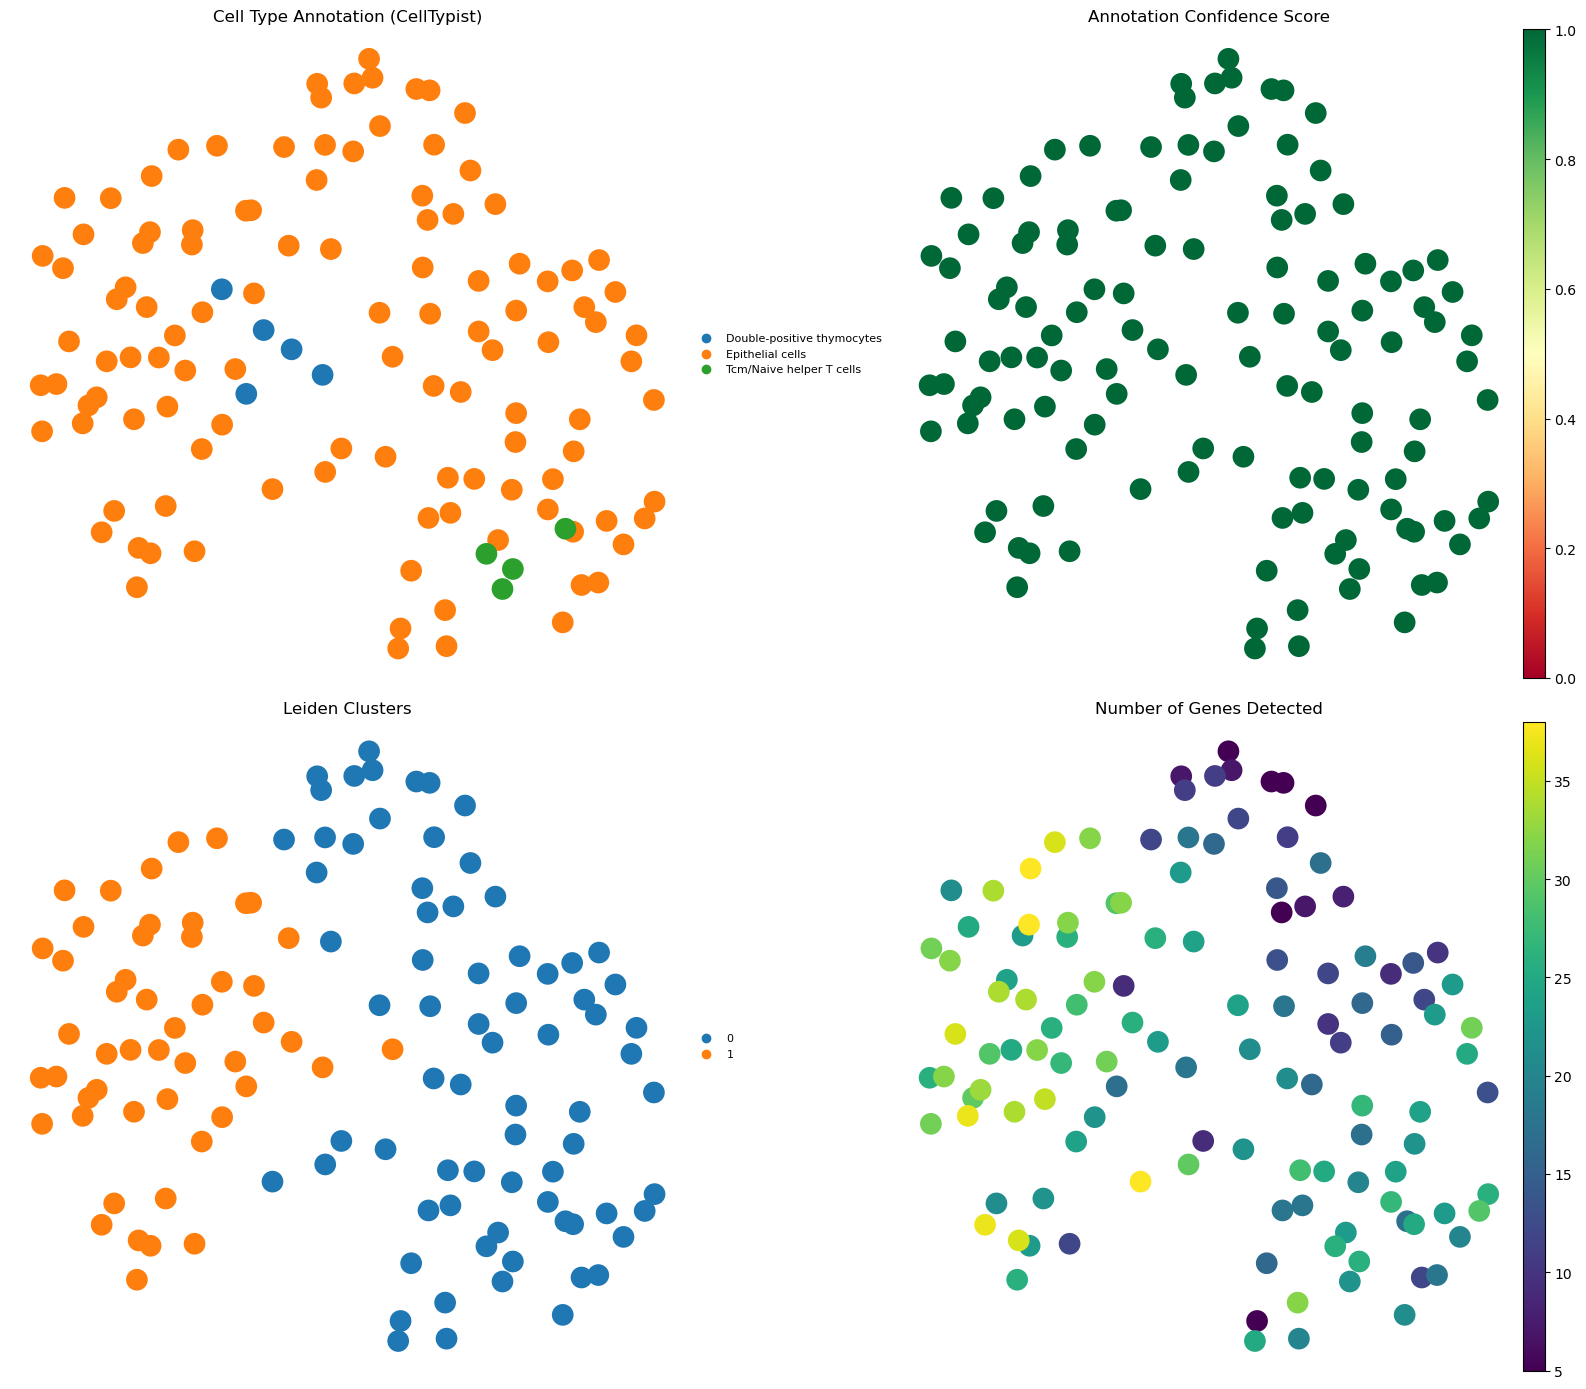


Cell Type Distribution by Cluster:
celltypist_cell_type  Double-positive thymocytes  Epithelial cells  \
leiden                                                               
0                                              0                69   
1                                              5                45   
All                                            5               114   

celltypist_cell_type  Tcm/Naive helper T cells  All  
leiden                                               
0                                            4   73  
1                                            0   50  
All                                          4  123  
✓ Distribution plot saved to: data/cell_type_distribution_final.png


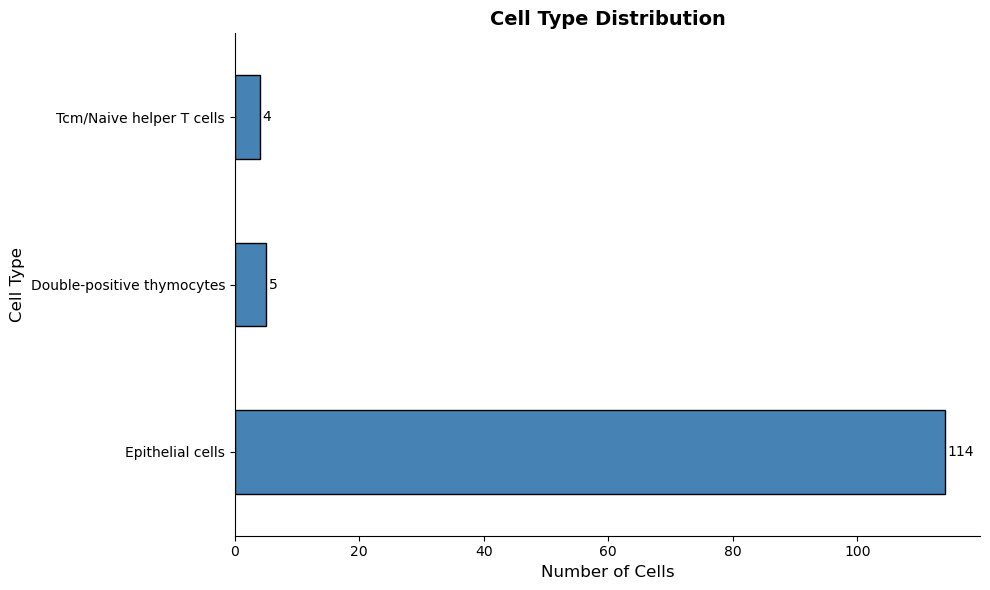


✓ Final annotated data saved to: data/adata_annotated_final.h5ad

CELL ANNOTATION COMPLETE!
Total cells: 123
Unique cell types: 3
Mean confidence: 1.000


In [9]:
## Step 4B: Cell Annotation with CellTypist (Using Gene Symbols)

import scanpy as sc
import celltypist
from celltypist import models
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load the data with gene symbols
print("Loading data with gene symbols...")
try:
    adata = sc.read_h5ad(data_dir / 'adata_clustered_with_symbols.h5ad')
    print(f"✓ Loaded: {adata.n_obs} cells × {adata.n_vars} genes")
except FileNotFoundError:
    print("Error: Please run the gene conversion script first!")
    raise

# Prepare data for CellTypist
if adata.raw is not None:
    adata_for_annotation = adata.raw.to_adata()
    print("Using raw data from adata.raw")
else:
    adata_for_annotation = adata.copy()
    print("Using current adata")

print(f"\nGene names (should be symbols): {adata_for_annotation.var_names[:10].tolist()}")

# Verify we have gene symbols (not Ensembl IDs)
if adata_for_annotation.var_names[0].startswith('ENSG'):
    print("\n⚠️  Warning: Still using Ensembl IDs! Run gene conversion first.")
    print("Genes detected:", adata_for_annotation.var_names[:5].tolist())
else:
    print("✓ Gene symbols detected")

# Load CellTypist model
print("\nLoading CellTypist model...")
model = models.Model.load(model='Immune_All_Low.pkl')
print(f"✓ Model loaded: Immune_All_Low.pkl")
print(f"  Model has {len(model.features)} genes")

# Check gene overlap
overlapping_genes = set(adata_for_annotation.var_names) & set(model.features)
print(f"\n📊 Gene overlap analysis:")
print(f"  Your genes: {adata_for_annotation.n_vars}")
print(f"  Model genes: {len(model.features)}")
print(f"  Overlapping genes: {len(overlapping_genes)}")
print(f"  Overlap rate: {100*len(overlapping_genes)/adata_for_annotation.n_vars:.1f}%")

if len(overlapping_genes) > 0:
    print(f"\n✓ Overlapping genes found: {sorted(list(overlapping_genes))[:10]}")
else:
    print("\n⚠️  No overlapping genes found!")

# Perform prediction
print("\nPerforming cell type prediction...")
try:
    predictions = celltypist.annotate(
        adata_for_annotation,
        model=model,
        majority_voting=True,
        mode='best match'
    )
    
    # Extract predictions - check the structure
    print(f"\nPrediction object attributes: {dir(predictions)}")
    print(f"Predicted labels type: {type(predictions.predicted_labels)}")
    
    # Check if it's a DataFrame
    if isinstance(predictions.predicted_labels, pd.DataFrame):
        print(f"Predicted labels columns: {predictions.predicted_labels.columns.tolist()}")
        print(f"Predicted labels shape: {predictions.predicted_labels.shape}")
        print(f"First few rows:\n{predictions.predicted_labels.head()}")
    else:
        print(f"Predicted labels attributes: {dir(predictions.predicted_labels)}")
    
    # Handle different CellTypist versions
    if hasattr(predictions.predicted_labels, 'majority_voting'):
        # Newer version
        adata.obs['celltypist_cell_type'] = predictions.predicted_labels.majority_voting
        adata.obs['celltypist_cell_type_initial'] = predictions.predicted_labels.predicted_labels
        
        # Get confidence scores
        if hasattr(predictions.predicted_labels, 'conf_score'):
            adata.obs['celltypist_conf_score'] = predictions.predicted_labels.conf_score
        elif 'conf_score' in predictions.predicted_labels.columns:
            adata.obs['celltypist_conf_score'] = predictions.predicted_labels['conf_score'].values
        else:
            print("Note: Confidence scores not available in this format")
            adata.obs['celltypist_conf_score'] = 1.0
    else:
        # Alternative structure (DataFrame-based)
        if 'majority_voting' in predictions.predicted_labels.columns:
            adata.obs['celltypist_cell_type'] = predictions.predicted_labels['majority_voting'].values
        elif 'predicted_labels' in predictions.predicted_labels.columns:
            adata.obs['celltypist_cell_type'] = predictions.predicted_labels['predicted_labels'].values
        else:
            # Use the index or first column
            adata.obs['celltypist_cell_type'] = predictions.predicted_labels.iloc[:, 0].values
        
        # Get confidence scores if available
        if 'conf_score' in predictions.predicted_labels.columns:
            adata.obs['celltypist_conf_score'] = predictions.predicted_labels['conf_score'].values
        else:
            adata.obs['celltypist_conf_score'] = 1.0
        
        adata.obs['celltypist_cell_type_initial'] = adata.obs['celltypist_cell_type']
    
    print("✓ Cell type prediction successful!")
    
    print(f"\nIdentified cell types:")
    print(adata.obs['celltypist_cell_type'].value_counts())
    
    print(f"\nConfidence score statistics:")
    print(f"  Mean: {adata.obs['celltypist_conf_score'].mean():.3f}")
    print(f"  Median: {adata.obs['celltypist_conf_score'].median():.3f}")
    print(f"  Min: {adata.obs['celltypist_conf_score'].min():.3f}")
    print(f"  Max: {adata.obs['celltypist_conf_score'].max():.3f}")
    
    # Identify low confidence predictions
    low_conf = adata.obs[adata.obs['celltypist_conf_score'] < 0.5]
    if len(low_conf) > 0:
        print(f"\n⚠️  {len(low_conf)} cells have low confidence (<0.5)")
    
    annotation_success = True

except Exception as e:
    print(f"\n⚠️  Prediction failed: {e}")
    print("\nUsing cluster-based labeling as fallback...")
    adata.obs['celltypist_cell_type'] = 'Cluster_' + adata.obs['leiden'].astype(str)
    adata.obs['celltypist_conf_score'] = 0.0
    annotation_success = False

# Create comprehensive visualization
print("\nGenerating annotated plots...")
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Cell types on UMAP
sc.pl.umap(
    adata, 
    color='celltypist_cell_type',
    ax=axes[0, 0],
    show=False,
    title='Cell Type Annotation (CellTypist)',
    legend_fontsize=8,
    legend_loc='right margin',
    frameon=False
)

# Plot 2: Confidence scores
sc.pl.umap(
    adata,
    color='celltypist_conf_score',
    ax=axes[0, 1],
    show=False,
    title='Annotation Confidence Score',
    cmap='RdYlGn',
    vmin=0,
    vmax=1,
    frameon=False
)

# Plot 3: Original Leiden clusters
sc.pl.umap(
    adata,
    color='leiden',
    ax=axes[1, 0],
    show=False,
    title='Leiden Clusters',
    legend_fontsize=8,
    frameon=False
)

# Plot 4: Number of genes detected
sc.pl.umap(
    adata,
    color='n_genes_by_counts',
    ax=axes[1, 1],
    show=False,
    title='Number of Genes Detected',
    cmap='viridis',
    frameon=False
)

plt.tight_layout()
plt.savefig(data_dir / 'cell_annotation_final.png', dpi=300, bbox_inches='tight')
print(f"✓ Annotation plot saved to: {data_dir / 'cell_annotation_final.png'}")
plt.show()

# Create summary table
if annotation_success:
    print("\n" + "="*60)
    print("Cell Type Distribution by Cluster:")
    print("="*60)
    ct_summary = pd.crosstab(
        adata.obs['leiden'],
        adata.obs['celltypist_cell_type'],
        margins=True
    )
    print(ct_summary)

# Cell type proportions bar plot
fig, ax = plt.subplots(figsize=(10, 6))
cell_type_counts = adata.obs['celltypist_cell_type'].value_counts()
cell_type_counts.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Number of Cells', fontsize=12)
ax.set_ylabel('Cell Type', fontsize=12)
ax.set_title('Cell Type Distribution', fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add count labels
for i, v in enumerate(cell_type_counts.values):
    ax.text(v + 0.5, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.savefig(data_dir / 'cell_type_distribution_final.png', dpi=300, bbox_inches='tight')
print(f"✓ Distribution plot saved to: {data_dir / 'cell_type_distribution_final.png'}")
plt.show()

# Save final annotated data
adata.write(data_dir / 'adata_annotated_final.h5ad')
print(f"\n✓ Final annotated data saved to: {data_dir / 'adata_annotated_final.h5ad'}")

print("\n" + "="*60)
print("CELL ANNOTATION COMPLETE!")
print("="*60)
print(f"Total cells: {adata.n_obs}")
print(f"Unique cell types: {adata.obs['celltypist_cell_type'].nunique()}")
if annotation_success:
    print(f"Mean confidence: {adata.obs['celltypist_conf_score'].mean():.3f}")

## Time Estimate: 8 Hours